In [1]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

tasting_name = "template"
tasting_dir = os.path.join(os.getcwd(), "data", tasting_name)
if len(sys.argv) > 3:
    tasting_dir = sys.argv[3]
scores_csv_path = os.path.join(tasting_dir, 'scores.csv')
subjects_json_path = os.path.join(tasting_dir, 'subjects.json')

# Read cider test data and preprocess
df = pd.read_csv(scores_csv_path)
df = df.join(df.groupby('connoisseur', group_keys=False)[['sötma','fyllighet','fruktsyra','betyg']].apply(lambda x: (x - x.mean()) / x.std()).add_prefix('norm_'))

# Read subject data and clean
subject_df = pd.read_json(subjects_json_path)
systemet_gradings_in = ['systemet_klocka_sötma', 'systemet_klocka_fyllighet', 'systemet_klocka_fruktsyra']
systemet_gradings_out = ['systemet_sötma', 'systemet_fyllighet', 'systemet_fruktsyra']
subject_df[systemet_gradings_out] = subject_df[systemet_gradings_in] / 60 * 10; 
subject_df = subject_df.drop(columns=systemet_gradings_in)

# Join and clean
df = df.set_index('subject_id').join(subject_df.set_index('subject_id')).reset_index()
df['subject_id_and_name'] = df['subject_id'].apply(lambda x: "Test "+str(x)) + df["subject_name"].apply(lambda x: " (" + str(x) + ")")

def saveAndShow(plt, x, y):
    date = datetime.today().strftime('%Y%m%d')
    outdir = os.path.join(tasting_dir,"out_" + date)
    if not os.path.exists(outdir):
        os.mkdir(outdir)

    name = tasting_name + "_" + x + "_vs_" + y + ".png"
    path = os.path.join(outdir, name)
    plt.savefig(path, format='png', transparent=False, bbox_inches = "tight")
    plt.show()


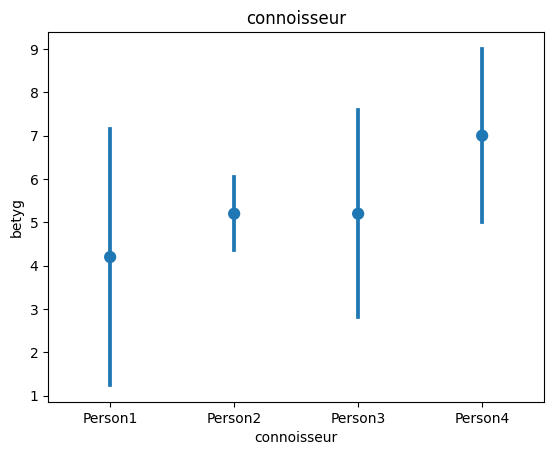

In [2]:
def pointplot(df,x,y):
  sns.pointplot(data=df, x=x, y=y, errorbar="sd", linestyles=" ", markers="o")
  plt.title(x)
  plt.show()

# pointplot(df, "connoisseur", "sötma")
# pointplot(df, "connoisseur", "fyllighet")
# pointplot(df, "connoisseur", "fruktsyra")
pointplot(df, "connoisseur", "betyg")


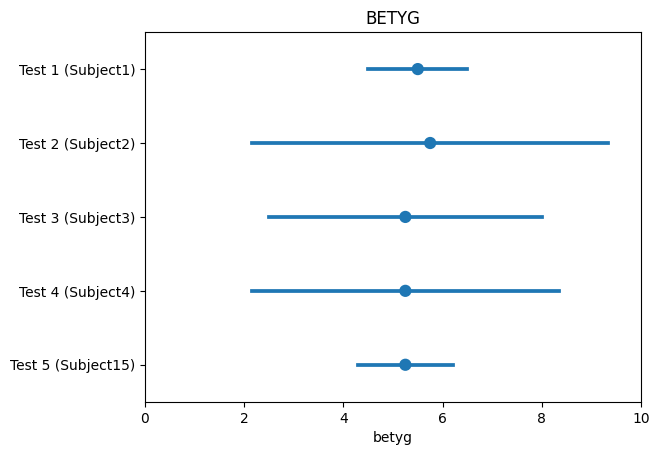

In [3]:
x = 'betyg'
y = 'subject_id_and_name'
sns.pointplot(data=df, x=x, y=y, errorbar="sd", linestyles="", dodge=True)
plt.title(x.upper())
plt.ylabel('')
plt.xlim([0, 10])
saveAndShow(plt, x, y)

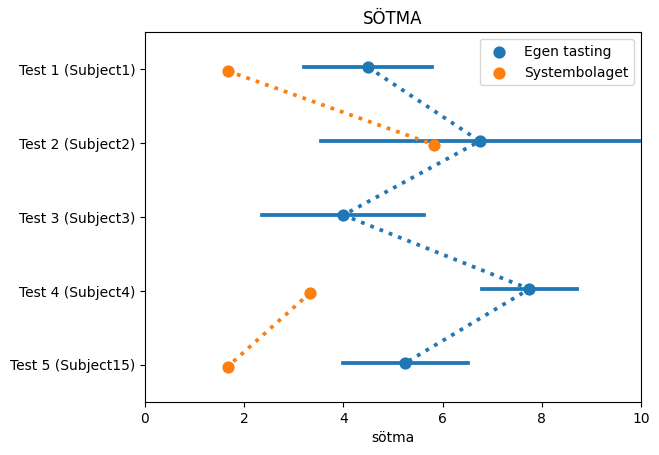

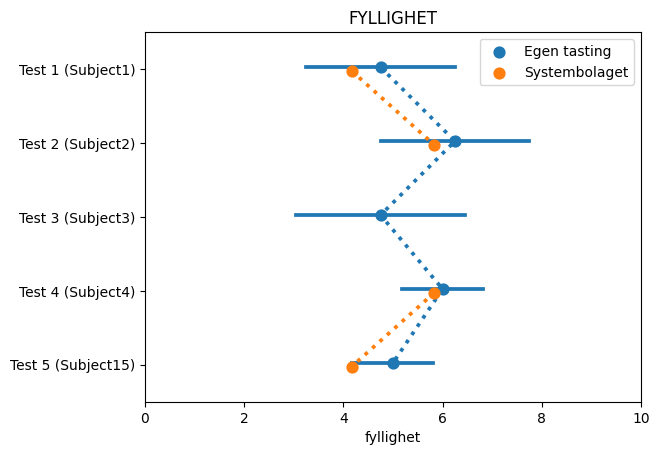

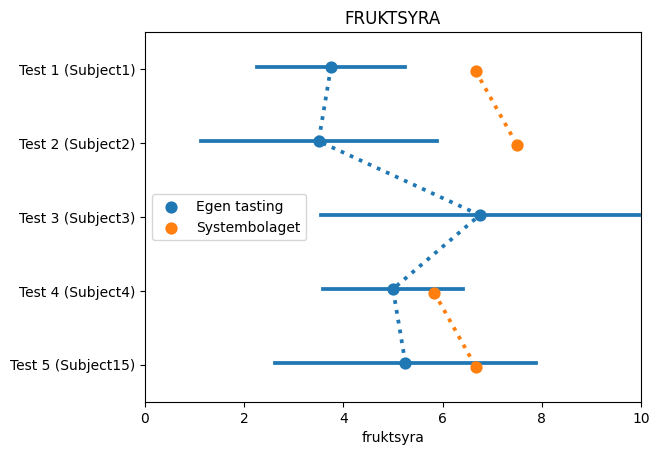

In [4]:
def plot_taste(df,x,y):
  score_type_col = ''

  test_df = pd.DataFrame()
  test_df[[x,y]] = df[[x,y]].copy()
  test_df.loc[:,score_type_col] = "Egen tasting"

  systemet_df = pd.DataFrame()
  systemet_df[[x,y]] = df[["systemet_"+x,y]].copy()
  systemet_df.loc[:,score_type_col] = 'Systembolaget'
  
  hue_df = pd.concat([test_df, systemet_df])
  sns.pointplot(data=hue_df, x=x, y=y, hue=score_type_col, errorbar="sd", linestyles="dotted", dodge=True)

  corr = round(test_df[x].corr(systemet_df[x]),2)
  plt.title(x.upper()
  #  + "\n(korrelation med systembolaget: " + str(corr) + ")"
  )
  plt.ylabel('')
  plt.xlim([0, 10])
  saveAndShow(plt, x, y)
  

plot_taste(df, "sötma", "subject_id_and_name")
plot_taste(df, "fyllighet", "subject_id_and_name")
plot_taste(df, "fruktsyra", "subject_id_and_name")


In [5]:

df.groupby('subject_id_and_name', group_keys=False).mean() \
  .sort_values('norm_betyg', ascending=False) \
  .drop(columns=['subject_id']) \
  .reset_index() \
  .rename(columns={'subject_id_and_name': "Test"})


/var/folders/ml/cm_hsndn21ddnl4ll0ntsmrm0000gn/T/ipykernel_55470/639018869.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby('subject_id_and_name', group_keys=False).mean() \


,Test,sötma,fyllighet,fruktsyra,betyg,norm_sötma,norm_fyllighet,norm_fruktsyra,norm_betyg,systemet_sötma,systemet_fyllighet,systemet_fruktsyra
0,Test 2 (Subject2),6.75,6.25,3.50,5.75,0.494526,0.950228,-0.510794,0.212211,5.833333,5.833333,7.500000
1,Test 1 (Subject1),4.50,4.75,3.75,5.50,-0.567175,-0.621893,-0.289094,0.140954,1.666667,4.166667,6.666667
2,Test 5 (Subject15),5.25,5.00,5.25,5.25,-0.224427,-0.384722,-0.031630,-0.004333,1.666667,4.166667,6.666667
3,Test 4 (Subject4),7.75,6.00,5.00,5.25,1.039657,0.660374,0.158529,-0.017503,3.333333,5.833333,5.833333
4,Test 3 (Subject3),4.00,4.75,6.75,5.25,-0.742581,-0.603987,0.672990,-0.331329,NaN,NaN,NaN


In [6]:

def systemet_taste_corr(_df):
  res = pd.DataFrame()
  for taste_col in ['sötma', 'fyllighet', 'fruktsyra']:
    res.loc[0,"systemet_corr_"+taste_col] = _df[taste_col].corr(_df['systemet_'+taste_col])
  return res

print(systemet_taste_corr(df))

corr_df = df.dropna().groupby('connoisseur', group_keys=True).apply(systemet_taste_corr).reset_index().drop(columns='level_1')
corr_df['mean'] = corr_df.mean(axis=1)
corr_df.sort_values(by="mean", ascending=False)


   systemet_corr_sötma  systemet_corr_fyllighet  systemet_corr_fruktsyra
0              0.40096                  0.51031                -0.274434


/var/folders/ml/cm_hsndn21ddnl4ll0ntsmrm0000gn/T/ipykernel_55470/3114732738.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  corr_df['mean'] = corr_df.mean(axis=1)


,connoisseur,systemet_corr_sötma,systemet_corr_fyllighet,systemet_corr_fruktsyra,mean
3,Person4,0.838250,0.904534,-3.956283e-01,0.449052
2,Person3,0.927201,0.707107,-4.264014e-01,0.402635
1,Person2,0.822903,1.000000,-7.071068e-01,0.371932
0,Person1,-0.365817,0.688247,7.536444e-16,0.107477


In [7]:

def fancy_systemet_corr(x,y):
  print("Korrelation med systembolaget %s, %s:" % (x, y))
  print("  [BASELINE] %s : %f" % (x, df[x].corr(df['systemet_'+x])))
  print("  %s / %s : %f" % (x, y, (df[x] / df[y]).corr(df['systemet_'+x] / df['systemet_'+y])))
  print("  %s + %s : %f" % (x, y, (df[x] + df[y]).corr(df['systemet_'+x] + df['systemet_'+y])))
  print("  %s * %s : %f" % (x, y, (df[x] * df[y]).corr(df['systemet_'+x] * df['systemet_'+y])))
  print("  %s - %s : %f" % (x, y, (df[x] - df[y]).corr(df['systemet_'+x] - df['systemet_'+y])))
  print("  %s / %s : %f" % (y, x, (df[y] / df[x]).corr(df['systemet_'+y] / df['systemet_'+x])))
  print("  %s - %s : %f" % (y, x, (df[y] - df[x]).corr(df['systemet_'+y] - df['systemet_'+x])))
  print()


fancy_systemet_corr("sötma", "fruktsyra")
fancy_systemet_corr("fruktsyra", "fyllighet")
fancy_systemet_corr("fyllighet", "sötma")



Korrelation med systembolaget sötma, fruktsyra:
  [BASELINE] sötma : 0.400960
  sötma / fruktsyra : 0.473154
  sötma + fruktsyra : 0.060660
  sötma * fruktsyra : -0.167399
  sötma - fruktsyra : 0.378118
  fruktsyra / sötma : 0.070698
  fruktsyra - sötma : 0.378118

Korrelation med systembolaget fruktsyra, fyllighet:
  [BASELINE] fruktsyra : -0.274434
  fruktsyra / fyllighet : 0.173268
  fruktsyra + fyllighet : 0.067729
  fruktsyra * fyllighet : -0.053680
  fruktsyra - fyllighet : 0.110217
  fyllighet / fruktsyra : 0.037641
  fyllighet - fruktsyra : 0.110217

Korrelation med systembolaget fyllighet, sötma:
  [BASELINE] fyllighet : 0.510310
  fyllighet / sötma : -0.099554
  fyllighet + sötma : 0.573321
  fyllighet * sötma : 0.577134
  fyllighet - sötma : -0.018340
  sötma / fyllighet : 0.020395
  sötma - fyllighet : -0.018340



In [8]:
tastes = ["sötma", "fyllighet", "fruktsyra"]
def print_corr(_df):
  print(_df.corr().round(2))

print("Egen tasting:")
print_corr(df[tastes])
print()

systemet_tastes = ["systemet_"+t for t in tastes]
print("Systembolaget:")
print_corr(df[systemet_tastes].rename(columns=dict(zip(systemet_tastes, tastes))))
print()

def print_corr_betyg(df, x):
  print("%s  %s" % (x.ljust(10), df[x].corr(df['betyg']).round(2)))

print("Smaker korrelerat med Betyg:")
for t in tastes: 
  print_corr_betyg(df, t)
print()

# print("Systemets smaker korrelerat med Betyg:")
for t in systemet_tastes: 
  print_corr_betyg(df, t)

Egen tasting:
           sötma  fyllighet  fruktsyra
sötma       1.00       0.47      -0.37
fyllighet   0.47       1.00      -0.03
fruktsyra  -0.37      -0.03       1.00

Systembolaget:
           sötma  fyllighet  fruktsyra
sötma       1.00       0.86       0.52
fyllighet   0.86       1.00       0.00
fruktsyra   0.52       0.00       1.00

Smaker korrelerat med Betyg:
sötma       0.5
fyllighet   0.44
fruktsyra   -0.21

systemet_sötma  0.07
systemet_fyllighet  0.03
systemet_fruktsyra  0.08


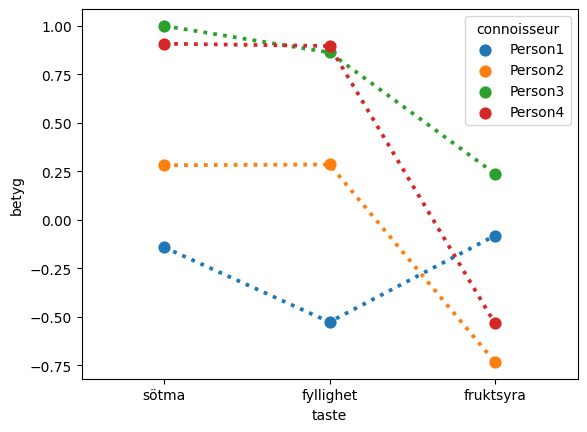

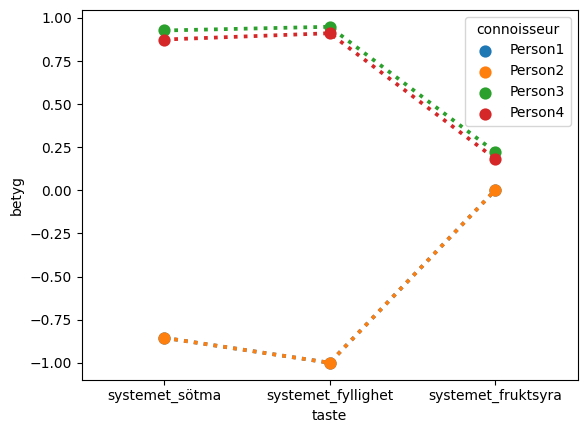

In [9]:
norm_tastes = ["norm_"+t for t in tastes]

def plot_connoisseur_taste(_tastes):
  connoisseur_tastes = df.groupby('connoisseur')[_tastes + ['betyg']].corr().reset_index().rename(columns={"level_1": "taste"})[['connoisseur', 'taste', 'betyg']]
  connoisseur_tastes = connoisseur_tastes[connoisseur_tastes['taste'] != 'betyg']
  sns.pointplot(data=connoisseur_tastes, x='taste', y='betyg', hue='connoisseur', linestyles='dotted')
  plt.show()


plot_connoisseur_taste(tastes)
plot_connoisseur_taste(systemet_tastes)